# Import

In [1]:
# Pour afficher les figures dans le notebook
%matplotlib inline
# Pour que les changements dans les modules importés soient pris en compte
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from Dataset import BLDataset
from preprocessing import processing_y2cat, processing_X2tokens, processing_tok2int, processing_max_length, processing_dataset_origin
from Multi_Models import BaselineModel, TwoWaysModel, VQModel, GRURepresentation

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mimmo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Variables

In [3]:
data_path = '../donnees'
litcovid_path = Path(data_path) / 'litcovid.json'
bibliovid_path = Path(data_path) / 'bibliovid.json'

title_len = 30
abstract_len = 500
batch_size = 64
embed_size = 128
hidden_size = 128
K = 25
D = 512
nb_labels = 3
device = torch.device('cpu') # can be changed to cuda if available

# Dataset

In [4]:
lit_dataset = BLDataset(litcovid_path)
bib_dataset = BLDataset(bibliovid_path)

In [5]:
x_fus, y_fus = lit_dataset.create_and_fuse(bib_dataset, shuffle=True, random_state=0).get_xy()

In [6]:
X_processed = processing_X2tokens(x_fus)
X_processed, vocab = processing_tok2int(X_processed)
X_processed = processing_max_length(X_processed, title_len, abstract_len)
X_origin = processing_dataset_origin(x_fus)
X_processed = torch.cat((X_processed, X_origin), -1)
X_processed = X_processed.to(device)

y_processed, len_topic, inv_label = processing_y2cat(y_fus, X_origin, get_inv_label=True)
y_processed = torch.FloatTensor(y_processed)
y_processed = y_processed.to(device)

In [7]:
baseset = TensorDataset(X_processed[:, :-1], y_processed)
twset = TensorDataset(X_processed, y_processed)

In [8]:
train_len = 3*X_processed.shape[0]//4
valid_len = X_processed.shape[0]//8
test_len = X_processed.shape[0] - train_len - valid_len

## Baseline dataset

In [9]:
train_set, valid_set, test_set = random_split(baseset, [train_len, valid_len, test_len], generator=torch.Generator().manual_seed(42))

train_baseloader = DataLoader(train_set, batch_size=batch_size)
valid_baseloader = DataLoader(valid_set, batch_size=batch_size)
test_baseloader = DataLoader(test_set, batch_size=batch_size)

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ],
       dtype=float32),
 <a list of 29741 BarContainer objects>)

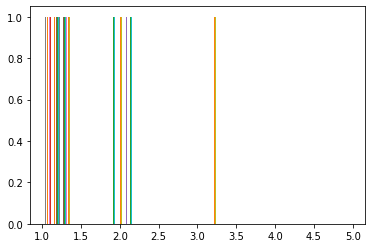

In [31]:
plt.hist(torch.sum(train_set[:][1], axis=1))

## Two-ways dataset

In [10]:
train_set, valid_set, test_set = random_split(twset, [train_len, valid_len, test_len], generator=torch.Generator().manual_seed(42))

train_TWloader = DataLoader(train_set, batch_size=batch_size)
valid_TWloader = DataLoader(valid_set, batch_size=batch_size)
test_TWloader = DataLoader(test_set, batch_size=batch_size)

# Baseline

In [11]:
base_model = BaselineModel(len(vocab), embed_size, hidden_size, y_processed.shape[1], title_len)
base_model.to(device)

BaselineModel(
  (repr): GRURepresentation(
    (embed): Embedding(160776, 128)
    (title_gru): GRU(128, 128, batch_first=True)
    (abstr_gru): GRU(128, 128, batch_first=True)
    (title_dropout): Dropout(p=0.3, inplace=False)
    (abstr_dropout): Dropout(p=0.3, inplace=False)
  )
  (decision): Linear(in_features=256, out_features=34, bias=True)
)

In [12]:
base_model.fit(train_baseloader, valid_baseloader, 5)

0 0.0014637509618126222 0.0011006932370394734 33.02360774818402
1 0.0009657044464325897 0.0008449663518596504 33.320621468926554
2 0.0007105918995654518 0.000672672996620698 33.47114608555287
3 0.0005543622497688012 0.0006038503652954169 33.52845036319613
4 0.0004391043442041699 0.0005986939437681384 33.53450363196126


In [13]:
torch.save(base_model.state_dict, "../modeles/base_model.pt")

In [ ]:
base_model = BaselineModel(len(vocab), embed_size, hidden_size, y_processed.shape[1], title_len)
base_model.load_state_dict(torch.load("../modeles/base_model.pt"))
base_model.eval()

y_pred, y_true = base_model.predict(test_baseloader)

In [ ]:
f1_score(y_true, y_pred, average='weighted')

# Modèle à deux branches

In [14]:
tw_model = TwoWaysModel(len(vocab), embed_size, hidden_size, *len_topic, title_len)
tw_model.to(device)

TwoWaysModel(
  (repr): GRURepresentation(
    (embed): Embedding(160776, 128)
    (title_gru): GRU(128, 128, batch_first=True)
    (abstr_gru): GRU(128, 128, batch_first=True)
    (title_dropout): Dropout(p=0.3, inplace=False)
    (abstr_dropout): Dropout(p=0.3, inplace=False)
  )
  (decision_0): Linear(in_features=256, out_features=9, bias=True)
  (decision_1): Linear(in_features=256, out_features=25, bias=True)
)

In [15]:
tw_model.fit(train_TWloader, valid_TWloader, 5)

Epoch 1:   0%|                                     | 0/465 [00:00<?, ?it/s]

 Dataset 0 - Loss : 0.004525795796307327 , Val_loss :  0.003825282183914543 , Perf :  0.204869223600727 
 Dataset 1 - Loss : 0.21957517132676882 , Val_loss :  0.894493360092914 , Perf :  0.8908472222796942


Epoch 2:   0%|                                     | 0/465 [00:00<?, ?it/s]

 Dataset 0 - Loss : 0.0029301205981052715 , Val_loss :  0.002458199730862981 , Perf :  0.19698595546059688 
 Dataset 1 - Loss : 0.1436998945771506 , Val_loss :  0.9403260885172045 , Perf :  0.8901692406605866


Epoch 3:   0%|                                     | 0/465 [00:00<?, ?it/s]

 Dataset 0 - Loss : 0.002039124876806662 , Val_loss :  0.00195080136824365 , Perf :  0.18749297751208482 
 Dataset 1 - Loss : 0.10072267440886333 , Val_loss :  0.9529189985577905 , Perf :  0.8928811671370167


Epoch 4:   0%|                                     | 0/465 [00:00<?, ?it/s]

 Dataset 0 - Loss : 0.0015751727585007248 , Val_loss :  0.0018754397146746118 , Perf :  0.18563547326346574 
 Dataset 1 - Loss : 0.07848792727251619 , Val_loss :  0.9554603145101593 , Perf :  0.8915251392429158


Epoch 4: 100%|███████████████████████████| 465/465 [07:02<00:00,  1.10it/s]


 Dataset 0 - Loss : 0.0012696361511040938 , Val_loss :  0.001960987114488823 , Perf :  0.18872211747250314 
 Dataset 1 - Loss : 0.06375867712143737 , Val_loss :  0.9568670271658669 , Perf :  0.8908471576238083


In [16]:
torch.save(tw_model.state_dict, "../modeles/tw_model.pt")

In [ ]:
tw_model = TwoWaysModel(len(vocab), embed_size, hidden_size, *len_topic, title_len)
tw_model.load_state_dict(torch.load("../modeles/tw_model.pt"))
tw_model.eval()

(y_pred_0, y_true_0), (y_pred_1, y_true_1) = tw_model.predict(test_TWloader)

In [ ]:
f1_score(y_true_0, y_pred_0, average='weighted')

In [ ]:
f1_score(y_true_1, y_pred_1, average='weighted')

# Baseline + VQ-VAE

In [33]:
vq_base = VQModel(base_model.repr, nb_labels, K, D)
vq_base.to(device)

VQModel(
  (cr): GRURepresentation(
    (embed): Embedding(160776, 128)
    (title_gru): GRU(128, 128, batch_first=True)
    (abstr_gru): GRU(128, 128, batch_first=True)
    (title_dropout): Dropout(p=0.3, inplace=False)
    (abstr_dropout): Dropout(p=0.3, inplace=False)
  )
  (vq_vae): VQ_VAE(
    (encoder): Encoder(
      (dense): Linear(in_features=256, out_features=514, bias=True)
      (conv): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
    )
    (vq): VectorQuantizer(
      (embedding): Embedding(25, 512)
    )
    (decoder): Decoder(
      (dense): Linear(in_features=514, out_features=256, bias=True)
      (conv): ConvTranspose1d(3, 1, kernel_size=(3,), stride=(1,))
    )
  )
)

In [34]:
vq_base.fit(train_baseloader, valid_baseloader, 20)

0 0.017110333382243617 0.009235047363195812
1 0.009958897378568848 0.00872424123410355
2 0.009113272476731792 0.008150033610688764
3 0.008736982165530576 0.007795583610095931
4 0.008336907424585576 0.0074621322320487056
5 0.008111343756235422 0.007377915625566432
6 0.00805341696587685 0.00734801758216022
7 0.0080256221462028 0.007265287573968719
8 0.00798341164427476 0.007209969713045186
9 0.007953579571671894 0.007203334029929305
10 0.007959881213168193 0.007141206777317087
11 0.007946310054638219 0.007138573481153345
12 0.00796498354391726 0.007137050321498545
13 0.007973335425064345 0.007135502356641999
14 0.007980719720269936 0.00713166178379259
15 0.00794230463493488 0.007064651712907525
16 0.007900395724573074 0.0070601145378325235
17 0.007899289487337426 0.007058707917525558
18 0.007907334555173817 0.0070566969162230535
19 0.007918776920418072 0.007056767134487485


In [35]:
torch.save(vq_base.state_dict, "../modeles/vq_base_model.pt")

# Two-ways + VQ-VAE

In [36]:
vq_tw = VQModel(tw_model.repr, nb_labels, K, D)

In [38]:
vq_tw.fit(train_TWloader, valid_TWloader, 20)

0 0.013450794091546453 0.007118893094222521
1 0.008595969909369627 0.00691287631441067
2 0.007791903144128986 0.006720777381515195
3 0.007389714297119248 0.006646473408707503
4 0.007276101935018444 0.006514145005749925
5 0.007164157163214617 0.006453515253690484
6 0.007174067561225048 0.006437279308053926
7 0.007207038825146909 0.006417297482298111
8 0.00723400452178599 0.0064075160245437406
9 0.0072309949251258745 0.006399279663262586
10 0.0072229487409925484 0.0063603993466152505
11 0.0072212116055969415 0.006354159981469361
12 0.007222873248656657 0.0062929731917727655
13 0.007209296786213149 0.006279185937478525
14 0.007242324794895178 0.006261735517137757
15 0.00726951761787803 0.006247055461995538
16 0.007306113593143283 0.006243046003305883
17 0.007328011157401155 0.006242196420636073
18 0.007348562586800941 0.006237854229480245
19 0.007364490126910934 0.006236164294682365


In [39]:
torch.save(vq_tw.state_dict, "../modeles/vq_tw_model.pt")

In [27]:
tw_model = TwoWaysModel(len(vocab), embed_size, hidden_size, *len_topic, title_len)
tw_model.load_state_dict(torch.load("../modeles/tw_model.pt"))
tw_model.eval()

vq_tw = VQModel(tw_model.repr, nb_labels, K, D)
vq_tw.load_state_dict(torch.load("../modeles/vq_tw_model.pt"))
vq_tw.eval()

AttributeError: 'function' object has no attribute 'copy'

In [ ]:
from tqdm import tqdm
import itertools 

encd_list, y_list = [], []
for x,y in tqdm(itertools.chain(train_TWloader,valid_TWloader, test_TWloader)):
    _, _, encd, _ = vq_tw(x[:,:title_len], x[:,title_len:])
    encd_list.append(encd)
    y_list.append(y)

In [ ]:
#data.post_process_topics(y_processed[:10], encd)
n, m = len(inv_label), K
corr = np.zeros((n, m), dtype='int32')

for source, dest in zip(y_list, encd_list):
    for ys, yd in zip(source, dest):
        for s_id, one_hot_s in enumerate(ys):
            if one_hot_s != 0:
                for d_id, one_hot_d in enumerate(yd):
                    if one_hot_d != 0:
                        corr[s_id, d_id] += 1

In [ ]:
maxi = max(np.max(normalize(corr, axis=1, norm='l1')), np.max(normalize(corr, axis=0, norm='l1')))

In [ ]:
import seaborn as sns
from sklearn.preprocessing import normalize

sns.set(font_scale=2)
plt.figure(figsize=(10,15))
sns.heatmap(data=normalize(corr, axis=1, norm='l1'), yticklabels=inv_label, cbar_kws={'label': 'Nombre de coocurences'}, vmax=maxi)
plt.xlabel("Topics du VQ-VAE")
plt.ylabel('Topics de Litcovid puis de Bibliovid')
plt.title('Matrice de coocurence normalisée sur les lignes')
plt.show()

sns.set(font_scale=2)
plt.figure(figsize=(10,10))
sns.heatmap(data=normalize(corr[:9], axis=1, norm='l1'), yticklabels=inv_label[:9], cbar_kws={'label': 'Nombre de coocurences'}, vmax=maxi)
plt.xlabel("Topics du VQ-VAE")
plt.ylabel('Topics de Litcovid')
plt.title('Matrice de coocurence normalisée sur les lignes')
plt.show()

sns.set(font_scale=2)
plt.figure(figsize=(10,15))
sns.heatmap(data=normalize(corr[9:], axis=1, norm='l1'), yticklabels=inv_label[9:], cbar_kws={'label': 'Nombre de coocurences'}, vmax=maxi)
plt.xlabel("Topics du VQ-VAE")
plt.ylabel('Topics de Bibliovid')
plt.title('Matrice de coocurence normalisée sur les lignes')
plt.show()

In [ ]:
import seaborn as sns
from sklearn.preprocessing import normalize

sns.set(font_scale=2)
plt.figure(figsize=(10,10))
sns.heatmap(data=normalize(corr[:9], axis=0, norm='l1'), yticklabels=inv_label[:9], cbar_kws={'label': 'Nombre de coocurences'}, vmax=maxi)
plt.xlabel("Topics du VQ-VAE")
plt.ylabel('Topics de Litcovid')
plt.title('Matrice de coocurence normalisée sur les colonnes')
plt.show()

sns.set(font_scale=2)
plt.figure(figsize=(10,15))
sns.heatmap(data=normalize(corr[9:], axis=0, norm='l1'), yticklabels=inv_label[9:], cbar_kws={'label': 'Nombre de coocurences'}, vmax=maxi)
plt.xlabel("Topics du VQ-VAE")
plt.ylabel('Topics de Bibliovid')
plt.title('Matrice de coocurence normalisée sur les colonnes')
plt.show()